# Few-Shot with a SVM
Creates a model that combines pybioclip image embeddings with a SVM using images from the [Somnath01/Birds_Species](https://huggingface.co/datasets/Somnath01/Birds_Species) dataset. This dataset contains 1000 train images, 403 test images, and 50 validation images. This notebook only uses the train and test images. This dataset was chosen for convenience. No analysis of the suitability of this dataset has been done.

When running this notebook in COLAB change the _runtime type_ to a GPU type to speed up processing. Additionally when running the next step in COLAB you you may see an error about the version of `fsspec` installed. This issue doesn't seem to cause any problem with this notebook.

In [1]:
!pip install -q numpy datasets pybioclip scikit-learn matplotlib

In [2]:
import itertools
import numpy as np
from tqdm.notebook import tqdm

import torch
from datasets import load_dataset

from bioclip.predict import BaseClassifier

import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm
import scipy.stats
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
# Dataset settings
HF_DATASET_NAME = "Somnath01/Birds_Species"
TRAIN_NAME = 'train'
TEST_NAME = 'test'
IMAGE_NAME = 'image'
LABEL_NAME = 'label'

# Image embedding settings
BATCH_SIZE = 30

## Determine GPU or CPU

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## Load dataset
This step takes around 7 minutes to download the images the first time it is run.

### Setting up HF_TOKEN (Recommended for Google Colab)

You may see warnings `The secret 'HF_TOKEN' does not exist in your Colab secrets.` when running the code block below. To avoid rate limiting errors when running in Google Colab, follow these steps to set up your HuggingFace token:

1. **Create a HuggingFace account and token:**
   - Go to [https://huggingface.co/](https://huggingface.co/) and create an account if you don't have one
   - Navigate to your [Access Tokens page](https://huggingface.co/settings/tokens)
   - Click "New token" and create a token with "Read" permissions
   - Copy the generated token

2. **Add the token as a Colab secret:**
   - In Google Colab, click the key icon (🔑) in the left sidebar to open the Secrets panel
   - Click "Add new secret"
   - Set the name to `HF_TOKEN`
   - Paste your HuggingFace token as the value
   - Click "Add secret"

3. **Grant notebook access to the secret:**
   - In the Secrets panel, find your `HF_TOKEN` secret
   - Toggle the switch next to the notebook name to grant access
   - The switch should turn blue/green when enabled

After setting up the token, restart your runtime (Runtime → Restart runtime) and re-run the cells above before proceeding.

In [5]:
dataset = load_dataset(HF_DATASET_NAME)
dataset

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/403 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 403
    })
})

Labels: ABBOTTS BABBLER,ABBOTTS BOOBY,ABYSSINIAN GROUND HORNBILL,AFRICAN CROWNED CRANE,AFRICAN EMERALD CUCKOO,AFRICAN FIREFINCH,AFRICAN OYSTER CATCHER,AFRICAN PIED HORNBILL,AFRICAN PYGMY GOOSE,ALBATROSS 

Example Image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x105EFCD00>


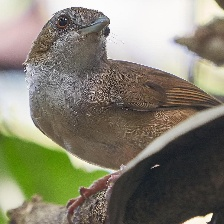

In [6]:
print("Labels:", ",".join(dataset[TRAIN_NAME].features[LABEL_NAME].names), "\n")
print("Example Image:", dataset[TRAIN_NAME][IMAGE_NAME][0])
dataset[TRAIN_NAME][IMAGE_NAME][0]

## Function to Convert PIL to image embeddings

In [7]:
classifier = BaseClassifier(device=device)

In [8]:
def batched(items, batch_size):
    it = iter(items)
    while (batch := list(itertools.islice(it, batch_size))):
          yield batch

In [9]:
def create_image_features(pil_image_ary):
    # batch PIL -> features transformation
    all_features = []
    with tqdm(total=len(pil_image_ary), desc='Creating image embeddings', unit='image') as progress_bar:
        for images in batched(pil_image_ary, BATCH_SIZE):
            features = classifier.create_image_features(images, normalize=True)
            all_features.append(features.cpu())
            progress_bar.update(len(images))
    return torch.cat(all_features, dim=0).cpu().numpy()

## Function to show prediction metrics

In [10]:
def show_metrics(expected_label_ary, predicted_label_ary):
    print("Accuracy:", round(accuracy_score(expected_label_ary, predicted_label_ary), 3))
    cm = confusion_matrix(expected_label_ary, predicted_label_ary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    disp.ax_.set_title("Confusion Matrix")
    plt.show()

## Setup a SVM model
The `init_svc()` function is copied from [biobench newt](https://github.com/samuelstevens/biobench/blob/637432bfda2b567d966d49bf8c4b37b339d4dc2a/biobench/newt/__init__.py#L247-L262) 
created by [@samuelstevens](https://github.com/samuelstevens).

In [11]:
def init_svc():
    """Create a new, randomly initialized SVM with a random hyperparameter search over kernel, C and gamma. It uses only 16 jobs in parallel to prevent overloading the CPUs on a shared machine."""
    return sklearn.model_selection.RandomizedSearchCV(
        sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(),
            sklearn.svm.SVC(C=1.0, kernel="rbf"),
        ),
        {
            "svc__C": scipy.stats.loguniform(a=1e-3, b=1e1),
            "svc__kernel": ["rbf", "linear", "sigmoid", "poly"],
            "svc__gamma": scipy.stats.loguniform(a=1e-4, b=1e-3),
        },
        n_iter=100,
        n_jobs=16,
        random_state=42,
    )

In [12]:
# Create a model that preprocesses images into feature embeddings that are passed to the SVM
svc = sklearn.pipeline.make_pipeline(
    FunctionTransformer(create_image_features),
    init_svc(),
)

## Train the SVM model
Trains the SVM using the train dataset. This step takes ~ 10 minutes when running on CPU and ~1 minute otherwise.

In [13]:
# Convert dataset columns to lists for Colab compatibility (sklearn requires list-like objects)
svc.fit(list(dataset[TRAIN_NAME][IMAGE_NAME]), list(dataset[TRAIN_NAME][LABEL_NAME]))

Creating image embeddings:   0%|          | 0/1000 [00:00<?, ?image/s]

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function create_image_features at 0x168574f70>)),
                ('randomizedsearchcv',
                 RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                                               StandardScaler()),
                                                              ('svc', SVC())]),
                                    n_iter=100, n_jobs=16,
                                    param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x168585f30>,
                                                         'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x168586170>,
                                                         'svc__kernel': ['rbf',
                                                                         'linear',
                                                                         'sigmoid',
                                                                         'poly']},
                                    random_state=42))])

## Create predictions
Predicts species for the test dataset. This step takes ~ 5 minutes when running on CPU and ~1 minute otherwise.

Creating image embeddings:   0%|          | 0/403 [00:00<?, ?image/s]

Accuracy: 0.998


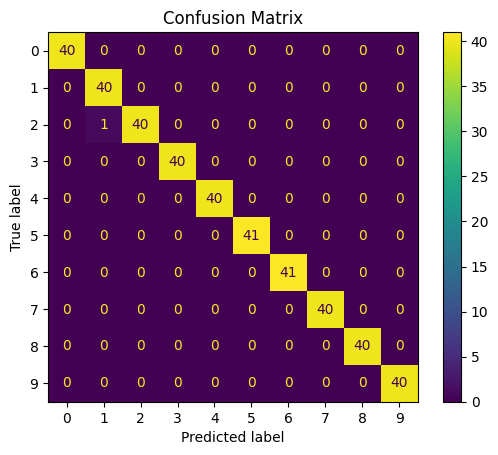

In [14]:
# Convert dataset columns to lists for Colab compatibility (sklearn requires list-like objects)
predicted_labels = svc.predict(list(dataset[TEST_NAME][IMAGE_NAME]))
show_metrics(predicted_labels, list(dataset[TEST_NAME][LABEL_NAME]))

## Compare against direct zero-shot pybioclip predictions
This step takes ~ 6 minutes when running on CPU and ~1 minute otherwise.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.45images/s]

Accuracy: 0.985


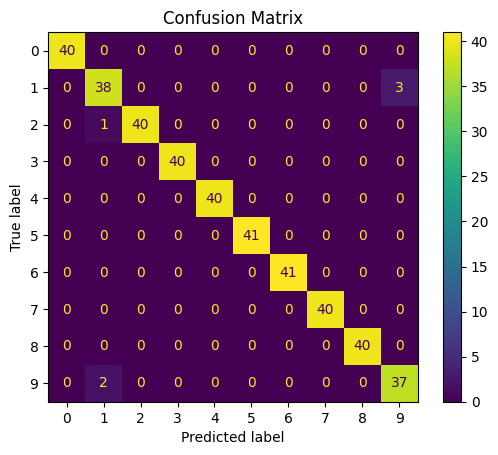

In [15]:
from bioclip.predict import CustomLabelsClassifier
classifier = CustomLabelsClassifier(dataset[TEST_NAME].features[LABEL_NAME].names, device=device)
predicted_labels = []
# Convert dataset columns to lists for Colab compatibility
for images in batched(list(dataset[TEST_NAME][IMAGE_NAME]), BATCH_SIZE):
    predictions = classifier.predict(images, k=1)
    for pred in predictions:
        label_str = pred['classification']
        label = dataset[TEST_NAME].features[LABEL_NAME].str2int(label_str)
        predicted_labels.append(label)
# Convert dataset columns to lists for Colab compatibility
show_metrics(predicted_labels, list(dataset[TEST_NAME][LABEL_NAME]))